In [4]:
import torch
import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize
from torch import nn
from torchsummary import summary

%matplotlib inline

### Load data CIFAR-10

In [5]:
data_path = "../data/cifar-10/"

transform = Compose([ToTensor(), 
                     Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))])

cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


### Create a small dataset

In [6]:
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']

train_set = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
val_set = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

### Visualize data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


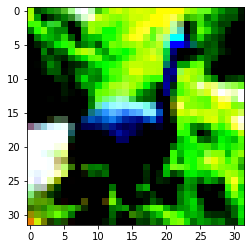

In [11]:
plt.imshow(train_set[0][0].permute(1, 2, 0))
plt.show()

### Build the model

In [33]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8*32, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        # conv block         
        x = self.conv_block(x)
        
        # classifier
        x = self.classifier(x)
        
        return x

In [34]:
model = Net()
summary(model, (3, 32, 32), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 16, 32, 32]             448
              ReLU-2            [1, 16, 32, 32]               0
         MaxPool2d-3            [1, 16, 16, 16]               0
            Conv2d-4            [1, 32, 16, 16]           4,640
              ReLU-5            [1, 32, 16, 16]               0
         MaxPool2d-6              [1, 32, 8, 8]               0
           Flatten-7                  [1, 2048]               0
            Linear-8                   [1, 512]       1,049,088
              ReLU-9                   [1, 512]               0
          Dropout-10                   [1, 512]               0
           Linear-11                    [1, 64]          32,832
             ReLU-12                    [1, 64]               0
          Dropout-13                    [1, 64]               0
           Linear-14                   

### Initialize params

In [38]:
learning_rate = 1e-2
optimzer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)

### Training the model

In [39]:
n_epochs = 10

def training_loops(n_epochs, model, train_loader, optimzer, loss_fn, verbose=1):
    for epoch in range(n_epochs):
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            out = model(imgs)
            loss = loss_fn(out, labels)

            optimzer.zero_grad()
            loss.backward()
            optimzer.step()

        if epoch % verbose == 0:
            print(f"Epoch {epoch} loss {loss:3f} %")

model.train()
training_loops(n_epochs, model, train_loader, optimzer, loss_fn)

Epoch 0 loss 0.121948 %
Epoch 1 loss 0.101016 %
Epoch 2 loss 0.477697 %
Epoch 3 loss 0.474845 %
Epoch 4 loss 0.295752 %
Epoch 5 loss 0.414453 %
Epoch 6 loss 0.348943 %
Epoch 7 loss 0.436883 %
Epoch 8 loss 0.568099 %
Epoch 9 loss 0.282434 %


### Measuring accuracy

In [40]:
def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print(f"Accuracy {name}: {correct/total:3f} %")

model.eval()
validate(model, train_loader, val_loader)

Accuracy train: 0.886500 %
Accuracy val: 0.856000 %


### Save the model

In [41]:
torch.save(model.state_dict(), "bird_vs_airplane.pt")

### Load the model

In [42]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load('bird_vs_airplane.pt'))

# loaded_model.eval()

<All keys matched successfully>